In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

In [28]:
# Import data and set appropriate column names
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
dataset = pd.read_csv('../data/iris/iris.data', header=None, names=column_names)
dataset.head()
    

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [29]:
# Separate features from targets
features = dataset.drop('class', axis=1)
targets = dataset['class']

In [30]:
# Check target distribution
targets.value_counts()

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [31]:
# Encode the targets using LabelEncoder so that we don't have issues with different encodings (LabelEncoder is used internally in scikit-learn)
targets_encoded = pd.Series(LabelEncoder().fit_transform(targets))

array([[<Axes: title={'center': 'sepal_length'}>,
        <Axes: title={'center': 'sepal_width'}>],
       [<Axes: title={'center': 'petal_length'}>,
        <Axes: title={'center': 'petal_width'}>]], dtype=object)

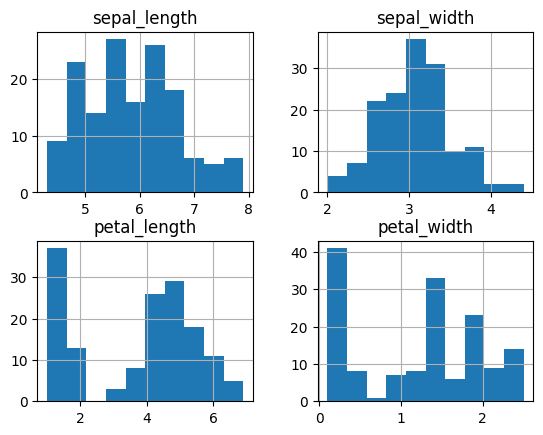

In [32]:
# Plot the distribution of all the features to investigate characteristics
# features.plot.hist()
features.hist()

In [33]:
# Correlation analysis
correlation = features.corr()
correlation.style.background_gradient('coolwarm')

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


In [34]:
# Mean scaling using Pandas. Can also be done with the StandardScaler in scikit-learn
features = (features - features.mean()) / features.std()
features.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-5.684342e-16,-7.815970e-16,-2.842171e-16,-3.789561e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.863780e+00,-2.425820e+00,-1.562342e+00,-1.442245e+00
25%,-8.976739e-01,-5.903951e-01,-1.222456e+00,-1.179859e+00
50%,-5.233076e-02,-1.315388e-01,3.353541e-01,1.320673e-01
75%,6.722490e-01,5.567457e-01,7.602115e-01,7.880307e-01
max,2.483699e+00,3.080455e+00,1.779869e+00,1.706379e+00


In [35]:
# Transform feature space using PCA to remove correlation. We try both 2 and 3 components to 
# see what works best
features_pca2 = pd.DataFrame(PCA(n_components=2).fit_transform(features))
features_pca3 = pd.DataFrame(PCA(n_components=3).fit_transform(features))

In [36]:
# Globals used in experiments

# Fixed random seed
global_random_state = 13

# The metrics we want to use 
scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict_proba'),
    # 'roc_auc': get_scorer('roc_auc_ovr'),
}

In [37]:
# A function for running tests on specified data
def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

In [38]:
# An ABC test between our data variants
print(cross_val_score(DecisionTreeClassifier(), X=features, y=targets_encoded))
print(cross_val_score(DecisionTreeClassifier(), X=features_pca2, y=targets_encoded))
print(cross_val_score(DecisionTreeClassifier(), X=features_pca3, y=targets_encoded))
print(cross_val_score(GaussianNB(), X=features, y=targets_encoded))
print(cross_val_score(GaussianNB(), X=features_pca2, y=targets_encoded))
print(cross_val_score(GaussianNB(), X=features_pca3, y=targets_encoded))
print(cross_val_score(SVC(), X=features, y=targets_encoded))
print(cross_val_score(SVC(), X=features_pca2, y=targets_encoded))
print(cross_val_score(SVC(), X=features_pca3, y=targets_encoded))

[0.96666667 0.96666667 0.9        0.93333333 1.        ]
[0.9        0.9        0.9        0.76666667 0.96666667]
[0.96666667 0.96666667 0.86666667 0.93333333 1.        ]
[0.93333333 0.96666667 0.93333333 0.93333333 1.        ]
[0.86666667 0.93333333 0.86666667 0.86666667 0.93333333]
[0.9        0.96666667 0.9        0.93333333 1.        ]
[0.96666667 0.96666667 0.96666667 0.93333333 1.        ]
[0.86666667 0.96666667 0.86666667 0.9        0.96666667]
[0.96666667 0.96666667 0.96666667 0.93333333 1.        ]


In [39]:
# We could do the same with cross_validate with all our metrics
print(cross_validate(DecisionTreeClassifier(), X=features, y=targets_encoded, scoring=scoring))

{'fit_time': array([0.0012188 , 0.00105166, 0.00105286, 0.00107861, 0.0010345 ]), 'score_time': array([0.00652575, 0.00629473, 0.00600576, 0.00607967, 0.00599885]), 'test_accuracy': array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ]), 'test_precision': array([0.96969697, 0.96969697, 0.9023569 , 0.96969697, 1.        ]), 'test_recall': array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ]), 'test_f1': array([0.96658312, 0.96658312, 0.89974937, 0.96658312, 1.        ]), 'test_roc_auc': array([0.975, 0.975, 0.925, 0.975, 1.   ])}


In [58]:
def train(estimator, params, scoring=scoring, refit='f1', random_state=global_random_state):

    # Manual nested cross validation

    # Create our iterators, one for the outer test folds, and one for the inner
    # grid search to find optimal paramater values
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=global_random_state)

    scores = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets_encoded):

        # Perform grid search to find optimal parameters
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets_encoded.iloc[train_index])
        # Evaluate the best estimator on the test fold
        evaluation = evaluate(grid, features.iloc[test_index], targets_encoded.iloc[test_index])
        scores.append(evaluation)
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))

    return estimators, pd.DataFrame(scores), pd.concat(cv_results, names=['test_split'], keys=range(5))

In [59]:
svc_params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
}
svc_estimators, svc_scores, svc_cv_results = train(SVC(probability=True, random_state=global_random_state), svc_params)
svc_scores.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.953333,0.953939,0.953333,0.953317,0.996333
std,0.029814,0.030182,0.029814,0.029805,0.003801
min,0.933333,0.933333,0.933333,0.933333,0.991667
25%,0.933333,0.933333,0.933333,0.933333,0.993333
50%,0.933333,0.933333,0.933333,0.933333,0.996667
75%,0.966667,0.969697,0.966667,0.966583,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='param_C', ylabel='mean_test_f1'>

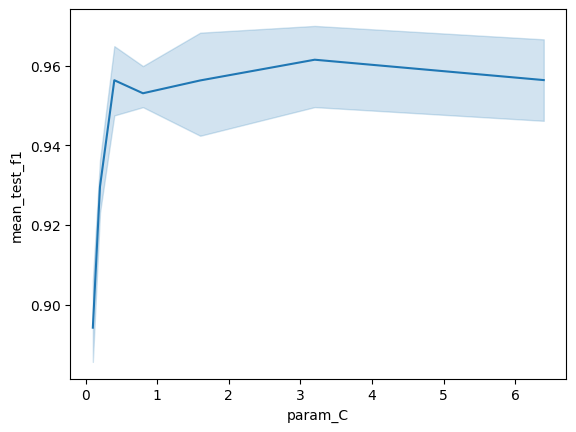

In [60]:
sb.lineplot(data=svc_cv_results, x='param_C', y='mean_test_f1')

In [44]:
binarized_targets = label_binarize(targets_encoded, classes=range(3))
binarized_targets[0:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [45]:
def plot_roc(estimators, features=features, targets=targets_encoded, random_state=global_random_state):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=global_random_state)
    fig, ax = plt.subplots(figsize=(6,6))
    for estimator_id, (estimator, (train_index, test_index)) in enumerate(zip(estimators, outer_cv.split(features, targets))):
        test_features = features.iloc[test_index]
        test_targets = targets.iloc[test_index]
        test_targets_binarized = label_binarize(test_targets, classes=estimator.classes_)
        probabilities = estimator.predict_proba(test_features)
        for class_id in estimator.classes_:
            RocCurveDisplay.from_predictions(
                test_targets_binarized[:,class_id], 
                probabilities[:, class_id], 
                ax=ax, 
                name=f'estimator {estimator_id} class {class_id}')


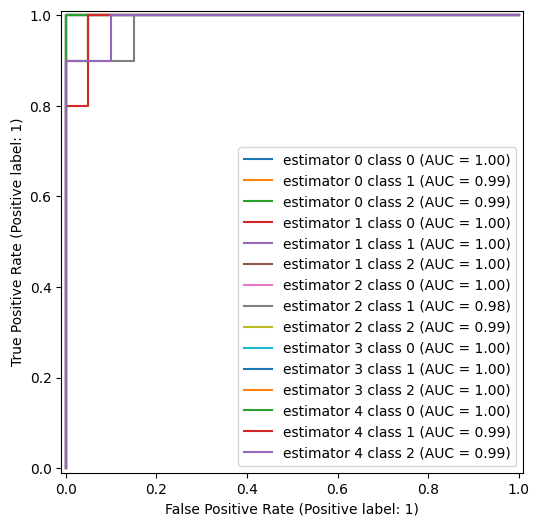

In [46]:
plot_roc(svc_estimators)

In [77]:
dt_params = {
    'max_depth': [2,3,4],
    'min_samples_split': [2,3,4,5,6],
    'criterion': ['gini', 'entropy', 'log_loss']
}
dt_estimators, dt_scores, dt_cv_results = train(
    DecisionTreeClassifier(random_state=global_random_state),
    dt_params)
dt_scores = pd.DataFrame(dt_scores)
dt_scores.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.946667,0.949966,0.946667,0.946465,0.961667
std,0.038006,0.036968,0.038006,0.038132,0.028013
min,0.900000,0.902357,0.900000,0.899749,0.925000
25%,0.933333,0.933333,0.933333,0.932660,0.950000
50%,0.933333,0.944444,0.933333,0.933333,0.958333
75%,0.966667,0.969697,0.966667,0.966583,0.975000
max,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='param_criterion', ylabel='mean_test_f1'>

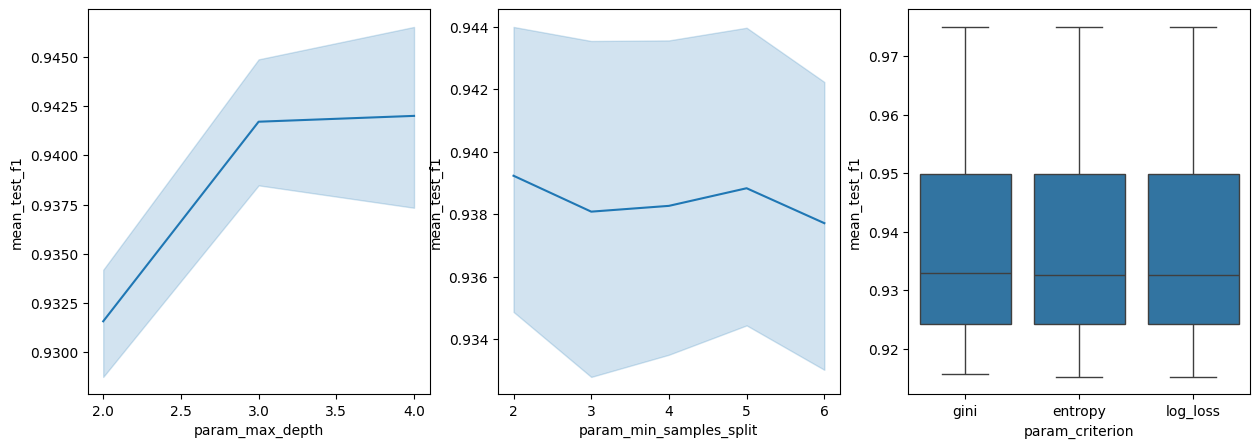

In [76]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
sb.lineplot(data=dt_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=dt_cv_results, x='param_min_samples_split', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=dt_cv_results, x='param_criterion', y='mean_test_f1', ax=ax[2])

In [ ]:
final_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],     
    'SVC': [svc_scores['accuracy'].mean(), svc_scores['precision'].mean(),  svc_scores['recall'].mean(), ],
    'DT': [dt_scores['accuracy'].mean(), dt_scores['precision'].mean(),  dt_scores['recall'].mean(), ]
})
final_results.set_index('Metric', inplace=True)
final_results

,SVC,DT
Metric,,
Accuracy,0.953333,0.946667
Precision,0.953939,0.949966
Recall,0.953333,0.946667
